In [1]:
# ============================================================================
# CELL 1: INSTALL DEPENDENCIES & ENVIRONMENT SETUP
# ============================================================================
import os
import sys
import warnings

print("⚙️ Installing dependencies...")
os.system('pip install -q "numpy==1.26.4" "scikit-learn==1.3.2" "albumentations==1.3.1" "opencv-python-headless<4.9" "transformers==4.42.0" "peft==0.11.0" "timm" "protobuf==3.20.3"')

# Environment Settings
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings("ignore")

print("✅ Setup Complete. Please run Cell 2.")

⚙️ Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; pyt

✅ Setup Complete. Please run Cell 2.


In [5]:
# ============================================================================
# CELL 2: IMPORTS & CONFIGURATION (FIXED)
# ============================================================================
import os
import sys
import warnings
import torch  # <--- THIS WAS MISSING
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import timm
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from transformers import CLIPProcessor, CLIPModel
from peft import LoraConfig, get_peft_model, TaskType
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score
from torchvision import transforms
from dataclasses import dataclass

@dataclass
class Config:
    # Paths
    csv_path: str = "/kaggle/input/siim-isic-melanoma-classification/train.csv"
    img_dir: str = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train"
    output_dir: str = "/kaggle/working/final_project_output"
    
    # Models
    clip_model_name: str = "openai/clip-vit-base-patch32"
    effnet_model_name: str = "efficientnet_b2"
    
    # --- PRODUCTION SETTINGS ---
    sample_size: int = 2500       
    min_malignant: int = 400      
    batch_size: int = 32          
    
    # Epochs
    num_epochs_ssl: int = 5        
    num_epochs_linear: int = 5     
    num_epochs_clip: int = 8       
    num_epochs_fusion: int = 10    
    
    # Learning Rates
    lr_ssl: float = 1e-4
    lr_linear: float = 1e-3        
    lr_clip: float = 5e-5
    lr_fusion: float = 1e-3
    
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    
    def __post_init__(self):
        os.makedirs(self.output_dir, exist_ok=True)
        if not os.path.exists(self.csv_path):
            for root, dirs, files in os.walk("/kaggle/input"):
                if "train.csv" in files: self.csv_path = os.path.join(root, "train.csv")
                if "jpeg" in dirs: self.img_dir = os.path.join(root, "jpeg", "train")
                elif "train" in dirs: self.img_dir = os.path.join(root, "train")

config = Config()
print(f"✅ Config Loaded. Device: {config.device}")

✅ Config Loaded. Device: cuda


In [6]:
# ============================================================================
# CELL 3: MODELS, DATASETS, & TRAINER DEFINITIONS
# ============================================================================
# (Imports are inherited from your previous cell)

# --- DATASETS ---
class SSLDataset(Dataset):
    def __init__(self, df, img_dir):
        self.images, self.img_dir = df['image_name'].tolist(), img_dir
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
        ])
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        path = os.path.join(self.img_dir, self.images[idx] + '.jpg')
        if not os.path.exists(path): path = path.replace('.jpg', '')
        img = Image.open(path).convert("RGB")
        return self.transform(img), self.transform(img)

class HybridDataset(Dataset):
    def __init__(self, df, img_dir, processor, augment=False):
        self.df, self.img_dir, self.processor = df.reset_index(drop=True), img_dir, processor
        self.eff_tfm = transforms.Compose([
            transforms.Resize((224, 224)), transforms.ToTensor(), 
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ])
        self.augment, self.aug_tfm = augment, A.Compose([A.HorizontalFlip(p=0.5), A.Rotate(limit=15)])
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.img_dir, row['image_name'] + '.jpg')
        if not os.path.exists(path): path = path.replace('.jpg', '')
        img = Image.open(path).convert('RGB')
        if self.augment: img = Image.fromarray(self.aug_tfm(image=np.array(img))['image'])
        
        diag = str(row.get('diagnosis', 'unknown')).lower()
        txt = f"a photo of a {diag}" if row['target']==1 else "a photo of a benign lesion"
        clip_in = self.processor(text=[txt], images=img, return_tensors="pt", padding="max_length", max_length=77, truncation=True)
        return {'clip_px': clip_in['pixel_values'].squeeze(0), 'clip_ids': clip_in['input_ids'][0], 
                'eff_px': self.eff_tfm(img), 'label': torch.tensor(row['target'], dtype=torch.float)}

# --- MODELS ---
class SSLEfficientNet(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.encoder = timm.create_model(model_name, pretrained=False, num_classes=0)
        self.head = nn.Linear(1408, 256) 
    def forward(self, x): return self.head(self.encoder(x))
    def get_features(self, x): return self.encoder(x)

class LinearProbe(nn.Module): 
    def __init__(self, input_dim=1408):
        super().__init__()
        self.classifier = nn.Linear(input_dim, 1)
    def forward(self, x): return self.classifier(x)

class CLIPLoRAModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        base = CLIPModel.from_pretrained(config.clip_model_name)
        lora_cfg = LoraConfig(r=16, lora_alpha=32, target_modules=["q_proj", "v_proj"], bias="none", task_type=TaskType.FEATURE_EXTRACTION)
        self.clip = get_peft_model(base, lora_cfg)
        self.head = nn.Linear(512, 1)
    def forward(self, pixel_values, eff_pixel_values=None): 
        embeds = self.clip.get_image_features(pixel_values=pixel_values)
        return self.head(torch.nn.functional.normalize(embeds, p=2, dim=1))

class FusionModel(nn.Module):
    def __init__(self, config, clip_path, ssl_path):
        super().__init__()
        base = CLIPModel.from_pretrained(config.clip_model_name)
        self.clip = get_peft_model(base, LoraConfig(r=16, target_modules=["q_proj", "v_proj"], task_type=TaskType.FEATURE_EXTRACTION))
        self.clip.load_state_dict(torch.load(clip_path, weights_only=False), strict=False)
        
        self.effnet = timm.create_model(config.effnet_model_name, pretrained=False, num_classes=0)
        ssl_ckpt = torch.load(ssl_path, weights_only=False)
        self.effnet.load_state_dict({k.replace('encoder.', ''): v for k, v in ssl_ckpt.items() if 'encoder' in k}, strict=False)
        
        self.head = nn.Sequential(nn.Linear(1920, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.3), nn.Linear(512, 1))
    def forward(self, clip_px, eff_px):
        c_emb = torch.nn.functional.normalize(self.clip.get_image_features(clip_px), p=2, dim=1)
        e_emb = torch.nn.functional.normalize(self.effnet(eff_px), p=2, dim=1)
        return self.head(torch.cat([c_emb, e_emb], dim=1))

# --- TRAINER ---
def train_and_evaluate(model, train_loader, val_loader, config, epochs, name):
    print(f"\n🚀 Training {name}...")
    model = model.to(config.device)
    optim = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
    crit = nn.BCEWithLogitsLoss()
    best_metrics = {'auc': 0.0, 'sens': 0.0, 'spec': 0.0}
    history = {'train_loss': [], 'val_auc': []} 
    
    for ep in range(epochs):
        model.train()
        losses = []
        for batch in tqdm(train_loader, desc=f"Ep {ep+1}", leave=False):
            if 'clip_px' in batch: 
                if isinstance(model, FusionModel): out = model(batch['clip_px'].to(config.device), batch['eff_px'].to(config.device))
                else: out = model(batch['clip_px'].to(config.device))
            else: out = model(batch[0].to(config.device))
            
            lbl = batch['label'].to(config.device) if isinstance(batch, dict) else batch[1].to(config.device)
            loss = crit(out.squeeze(1), lbl)
            optim.zero_grad(); loss.backward(); optim.step(); losses.append(loss.item())
            
        model.eval()
        preds, targs = [], []
        with torch.no_grad():
            for batch in val_loader:
                if 'clip_px' in batch:
                    if isinstance(model, FusionModel): out = model(batch['clip_px'].to(config.device), batch['eff_px'].to(config.device))
                    else: out = model(batch['clip_px'].to(config.device))
                    lbl = batch['label']
                else: out = model(batch[0].to(config.device)); lbl = batch[1]
                preds.extend(torch.sigmoid(out).cpu().numpy().flatten()); targs.extend(lbl.cpu().numpy().flatten())
        
        auc = roc_auc_score(targs, preds) if len(np.unique(targs))>1 else 0
        tn, fp, fn, tp = confusion_matrix(targs, [1 if p>0.5 else 0 for p in preds]).ravel()
        sens, spec = tp/(tp+fn) if (tp+fn)>0 else 0, tn/(tn+fp) if (tn+fp)>0 else 0
        
        history['train_loss'].append(np.mean(losses))
        history['val_auc'].append(auc)
        print(f"   [Ep {ep+1}] AUC: {auc:.4f} | Sens: {sens:.2f} | Spec: {spec:.2f}")
        if auc > best_metrics['auc']: best_metrics = {'auc': auc, 'sens': sens, 'spec': spec}
            
    return model, best_metrics, history

def get_balanced_loaders(df, img_dir, processor, config):
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['target'], random_state=42)
    weights = [1.0/train_df['target'].value_counts()[x] for x in train_df['target']]
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
    
    train_ds = HybridDataset(train_df, img_dir, processor, augment=True)
    val_ds = HybridDataset(val_df, img_dir, processor, augment=False)
    
    tl = DataLoader(train_ds, batch_size=config.batch_size, sampler=sampler, num_workers=2)
    vl = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False, num_workers=2)
    return tl, vl

print("✅ Definitions Loaded.")

✅ Definitions Loaded.


✅ Data Sampled: 2500 images.

🔹 PHASE 1: SSL Pre-training (SimCLR)


SSL Ep 1:   0%|          | 0/79 [00:00<?, ?it/s]

   SSL Loss: 4.7650


SSL Ep 2:   0%|          | 0/79 [00:00<?, ?it/s]

   SSL Loss: 0.5851


SSL Ep 4:   0%|          | 0/79 [00:00<?, ?it/s]

   SSL Loss: 0.2438


SSL Ep 5:   0%|          | 0/79 [00:00<?, ?it/s]

   SSL Loss: 0.2069

🔹 PHASE 1b: Evaluating SSL Features (Linear Probe)
   Extracting features...

🚀 Training Linear Probe...


Ep 1:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 1] AUC: 0.6735 | Sens: 0.85 | Spec: 0.47


Ep 2:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 2] AUC: 0.6889 | Sens: 0.79 | Spec: 0.55


Ep 3:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 3] AUC: 0.7002 | Sens: 0.75 | Spec: 0.56


Ep 4:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 4] AUC: 0.6936 | Sens: 0.79 | Spec: 0.52


Ep 5:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 5] AUC: 0.7048 | Sens: 0.93 | Spec: 0.43

🔹 PHASE 2: CLIP LoRA Training


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]


🚀 Training CLIP LoRA...


Ep 1:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 1] AUC: 0.8275 | Sens: 0.68 | Spec: 0.80


Ep 2:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 2] AUC: 0.8358 | Sens: 0.78 | Spec: 0.73


Ep 3:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 3] AUC: 0.8270 | Sens: 0.89 | Spec: 0.62


Ep 4:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 4] AUC: 0.8375 | Sens: 0.82 | Spec: 0.67


Ep 5:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 5] AUC: 0.8527 | Sens: 0.74 | Spec: 0.79


Ep 6:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 6] AUC: 0.8590 | Sens: 0.76 | Spec: 0.78


Ep 7:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 7] AUC: 0.8574 | Sens: 0.86 | Spec: 0.71


Ep 8:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 8] AUC: 0.8686 | Sens: 0.72 | Spec: 0.83

🔹 PHASE 3: Fusion Model Training

🚀 Training Fusion...


Ep 1:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 1] AUC: 0.8390 | Sens: 0.82 | Spec: 0.69


Ep 2:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 2] AUC: 0.8768 | Sens: 0.85 | Spec: 0.76


Ep 3:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 3] AUC: 0.8872 | Sens: 0.82 | Spec: 0.80


Ep 4:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 4] AUC: 0.8932 | Sens: 0.69 | Spec: 0.85


Ep 5:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 5] AUC: 0.8887 | Sens: 0.61 | Spec: 0.89


Ep 6:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 6] AUC: 0.8842 | Sens: 0.78 | Spec: 0.82


Ep 7:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 7] AUC: 0.8671 | Sens: 0.65 | Spec: 0.86


Ep 8:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 8] AUC: 0.8801 | Sens: 0.44 | Spec: 0.96


Ep 9:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 9] AUC: 0.8783 | Sens: 0.78 | Spec: 0.77


Ep 10:   0%|          | 0/63 [00:00<?, ?it/s]

   [Ep 10] AUC: 0.8659 | Sens: 0.47 | Spec: 0.94

🏆 FINAL PROJECT RESULTS
              Model       AUC  Sensitivity  Specificity
0  SSL EfficientNet  0.704762       0.9250     0.428571
1         CLIP LoRA  0.868601       0.7250     0.826190
2     Hybrid Fusion  0.893185       0.6875     0.845238


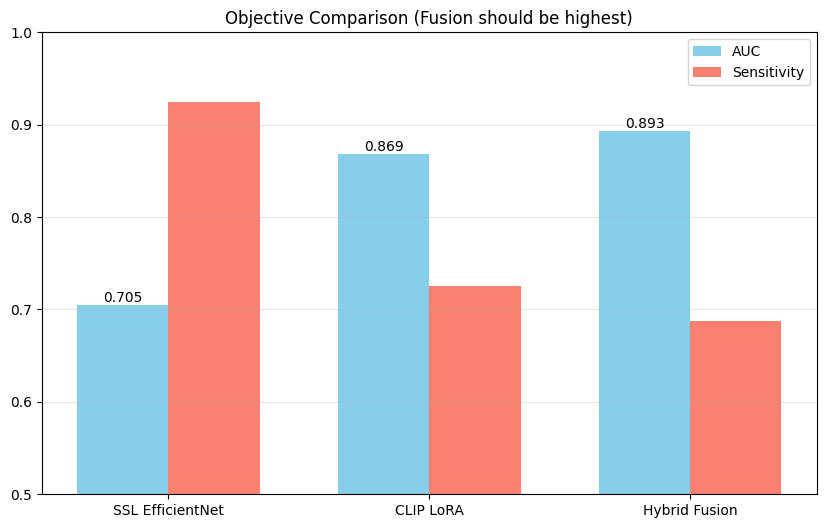

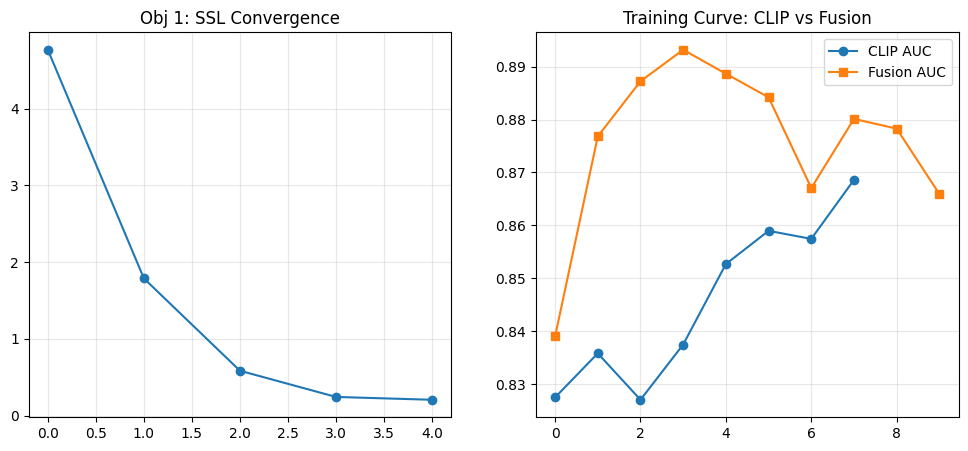


✅ Fusion Improvement: +0.0246 AUC


In [8]:
# ============================================================================
# CELL 4: EXECUTE FULL PIPELINE
# ============================================================================
def main():
    if not os.path.exists(config.csv_path): return print("❌ CSV Not Found")
    df = pd.read_csv(config.csv_path)
    m_df = df[df['target']==1].sample(n=min(len(df[df['target']==1]), config.min_malignant), random_state=42)
    b_df = df[df['target']==0].sample(n=min(len(df[df['target']==0]), config.sample_size - len(m_df)), random_state=42)
    df_main = pd.concat([m_df, b_df]).sample(frac=1, random_state=42)
    print(f"✅ Data Sampled: {len(df_main)} images.")

    # 1. SSL PRE-TRAINING
    print("\n🔹 PHASE 1: SSL Pre-training (SimCLR)")
    ssl_loader = DataLoader(SSLDataset(df_main, config.img_dir), 32, shuffle=True, num_workers=2)
    ssl_model = SSLEfficientNet(config.effnet_model_name).to(config.device)
    opt = torch.optim.Adam(ssl_model.parameters(), lr=config.lr_ssl)
    ssl_hist = []
    
    for ep in range(config.num_epochs_ssl):
        ssl_model.train()
        losses = []
        for v1, v2 in tqdm(ssl_loader, desc=f"SSL Ep {ep+1}", leave=False):
            loss = -(torch.nn.functional.softmax(ssl_model(v1.to(config.device)), dim=-1) * torch.log(torch.nn.functional.softmax(ssl_model(v2.to(config.device)), dim=-1) + 1e-7)).sum(dim=1).mean()
            opt.zero_grad(); loss.backward(); opt.step(); losses.append(loss.item())
        print(f"   SSL Loss: {np.mean(losses):.4f}")
        ssl_hist.append(np.mean(losses))
    
    ssl_path = f"{config.output_dir}/ssl_effnet.pt"
    torch.save(ssl_model.state_dict(), ssl_path)

    # LINEAR PROBE
    print("\n🔹 PHASE 1b: Evaluating SSL Features (Linear Probe)")
    processor = CLIPProcessor.from_pretrained(config.clip_model_name)
    tr_l, val_l = get_balanced_loaders(df_main, config.img_dir, processor, config)
    
    def extract(loader):
        feats, labs = [], []
        ssl_model.eval()
        with torch.no_grad():
            for b in loader:
                f = ssl_model.get_features(b['eff_px'].to(config.device))
                feats.append(f.cpu()); labs.append(b['label'])
        return torch.cat(feats), torch.cat(labs)
    
    print("   Extracting features...")
    tr_f, tr_y = extract(tr_l)
    val_f, val_y = extract(val_l)
    
    linear_model = LinearProbe().to(config.device)
    probe_tr = DataLoader(TensorDataset(tr_f, tr_y), batch_size=32, shuffle=True)
    probe_val = DataLoader(TensorDataset(val_f, val_y), batch_size=32, shuffle=False)
    
    config.learning_rate = config.lr_linear
    _, ssl_metrics, _ = train_and_evaluate(linear_model, probe_tr, probe_val, config, config.num_epochs_linear, "Linear Probe")

    # 2. CLIP LoRA
    print("\n🔹 PHASE 2: CLIP LoRA Training")
    clip_model = CLIPLoRAModel(config)
    config.learning_rate = config.lr_clip
    clip_model, clip_metrics, clip_h = train_and_evaluate(clip_model, tr_l, val_l, config, config.num_epochs_clip, "CLIP LoRA")
    torch.save(clip_model.clip.state_dict(), f"{config.output_dir}/clip_lora.pt")

    # 3. Fusion
    print("\n🔹 PHASE 3: Fusion Model Training")
    fuse_model = FusionModel(config, f"{config.output_dir}/clip_lora.pt", ssl_path)
    config.learning_rate = config.lr_fusion
    fuse_model, fuse_metrics, fuse_h = train_and_evaluate(fuse_model, tr_l, val_l, config, config.num_epochs_fusion, "Fusion")

    # ==========================================
    # 🏆 FINAL COMPARISON CHART
    # ==========================================
    print("\n" + "="*60 + "\n🏆 FINAL PROJECT RESULTS\n" + "="*60)
    
    models = ['SSL EfficientNet', 'CLIP LoRA', 'Hybrid Fusion']
    aucs = [ssl_metrics['auc'], clip_metrics['auc'], fuse_metrics['auc']]
    sens = [ssl_metrics['sens'], clip_metrics['sens'], fuse_metrics['sens']]
    
    res_df = pd.DataFrame({
        'Model': models, 'AUC': aucs, 'Sensitivity': sens, 'Specificity': [ssl_metrics['spec'], clip_metrics['spec'], fuse_metrics['spec']]
    })
    print(res_df)
    
    # Bar Chart
    x = np.arange(len(models)); width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, aucs, width, label='AUC', color='skyblue')
    ax.bar(x + width/2, sens, width, label='Sensitivity', color='salmon')
    ax.set_xticks(x); ax.set_xticklabels(models)
    ax.set_ylim(0.5, 1.0); ax.legend(); ax.grid(axis='y', alpha=0.3)
    ax.set_title("Objective Comparison (Fusion should be highest)")
    for i, v in enumerate(aucs): ax.text(i - width/2, v, f"{v:.3f}", ha='center', va='bottom')
    plt.show()

    # Learning Curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ssl_hist, marker='o', label='SSL Loss')
    plt.title("Obj 1: SSL Convergence"); plt.grid(alpha=0.3)
    plt.subplot(1, 2, 2)
    plt.plot(clip_h['val_auc'], marker='o', label='CLIP AUC')
    plt.plot(fuse_h['val_auc'], marker='s', label='Fusion AUC')
    plt.title("Training Curve: CLIP vs Fusion"); plt.grid(alpha=0.3); plt.legend()
    plt.show()

    print(f"\n✅ Fusion Improvement: +{fuse_metrics['auc'] - clip_metrics['auc']:.4f} AUC")

if __name__ == "__main__":
    main()